In [2]:
import mesa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import networkx as nx   

from enum import Enum

sns.set(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### simple risk-tolerance threshold approach

In [187]:
class State(Enum):
    MOVE = 1
    NO_MOVE = 0

class userAgent(mesa.Agent):
    
    def __init__( self, unique_id, model, PT, B, R, d):
        
        super().__init__(unique_id, model)
        
#         mean = 0
#         std_dev = 1
#         self.opinion = np.random.normal(mean, std_dev)

        self.opinion = random.uniform(0, 1) 
    
        if PT == -1:
            self.peer_trust = random.uniform(0, 1)
        else:
            self.peer_trust = PT
        
        if B == -1:
            self.tendency_to_share = random.uniform(0, 1)
        else:
            self.tendency_to_share = B
        
        if R == -1:
            temp = random.uniform(0, 1)
            if temp < 1.0/3.0:
                self.risk_sensitivity = 0 
            else:
                temp2 = random.uniform(0, 1)
                if temp2 < 0.5:
                    self.risk_sensitivity = 2 
                else:
                    self.risk_sensitivity = 1 
        else:
            self.risk_sensitivity = R
                
        # decision making
        if d == -1:
            self.decision_th = random.uniform(0, 1)
        else:
            self.decision_th = d
        
        if self.opinion < self.decision_th:
            self.decision = 1
        elif self.opinion >= self.decision_th:
            self.decision = 0
            
        self.mobility_state = self.set_mobility_state(self.decision)
        
  
    def set_mobility_state(self, decision):
        if decision == 0:
            return State.NO_MOVE
        else:
            return State.MOVE
        
        
    def update_opinion(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                if self.risk_sensitivity == 0:
                    self.opinion = self.opinion / 2.0
                elif self.risk_sensitivity == 2:
                    self.opinion = (1.0 + self.opinion) / 2.0
            
            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                if other_agent.risk_sensitivity == 0:
                    other_agent.opinion = other_agent.opinion / 2.0
                elif other_agent.risk_sensitivity == 2:
                    other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
    
    def make_mobililty_decision(self, opinion):
        if opinion < self.decision_th:
            self.decision = 1
        elif opinion >= self.decision_th:
            self.decision = 0
            
        self.mobility_state = self.set_mobility_state(self.decision)
        
        
    def step(self):
        self.update_opinion()

        self.make_mobililty_decision(self.opinion)
        
def opinion_avg(model):
    return sum(a.opinion for a in model.grid.get_all_cell_contents())/model.num_agents

def mobility_count(model):
    return sum(1 for a in model.grid.get_all_cell_contents() if a.mobility_state is State.MOVE)
    
def no_mobility_count(model):
    return sum(1 for a in model.grid.get_all_cell_contents() if a.mobility_state is State.NO_MOVE)

def mobility_rate(model):
    return mobility_count(model)/model.num_agents

class opinionsModel(mesa.Model):
    
    def __init__(self, N, PT = -1, B = -1, R = -1, d = -1):
      
        self.num_agents = N
        self.PT = PT
        self.B = B
        self.R = R
        self.d = d

        self.G = nx.complete_graph(n = self.num_agents)
        
#         avg_node_degree = 3
#         prob = avg_node_degree / self.num_agents
#         self.G = nx.erdos_renyi_graph(n=self.num_agents, p=prob)
        
        
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "op_avg": opinion_avg,
                "moving" : mobility_count,
                "not_moving" : no_mobility_count,
                "mobility_rate" : mobility_rate,
            },
            agent_reporters = {
                "opinion" : "opinion", 
                "peer_trust" : "peer_trust",
                "risk_sensitivity": "risk_sensitivity",
                "tendency_to_share" : "tendency_to_share",
                "decision_th" : "decision_th",
                "decision" : "decision",
                "mobility_state" : "mobility_state"
            }
        )

        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)

        for i, node in enumerate(self.G.nodes()):           
            a = userAgent(i, self, self.PT, self.B, self.R, self.d)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
            
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)        

### Decision making with the complete opinion update function

In [143]:
model = opinionsModel(N = 500)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

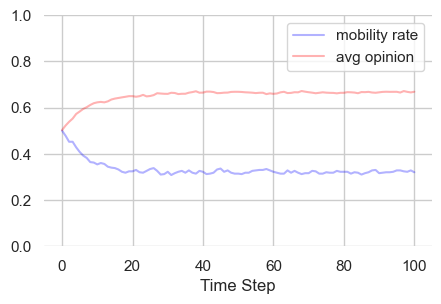

In [144]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

# Risk sensitivity
### 1. R = 0 (non-alarmist)

In [145]:
model = opinionsModel(N = 500, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

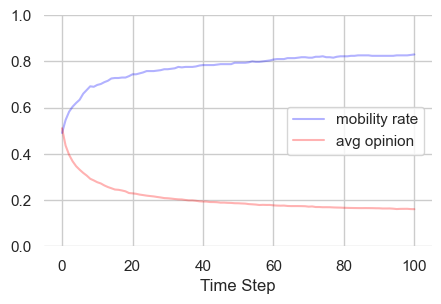

In [146]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 2. R = 1 (netrual)

In [147]:
model = opinionsModel(N = 500, R = 1)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

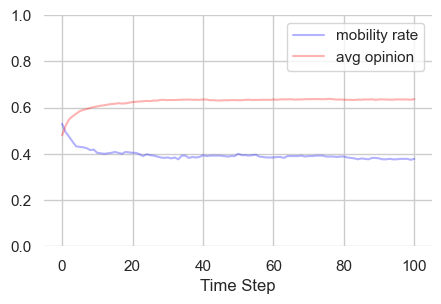

In [148]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 3. R = 2 (alarmist)

In [149]:
model = opinionsModel(N = 500, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

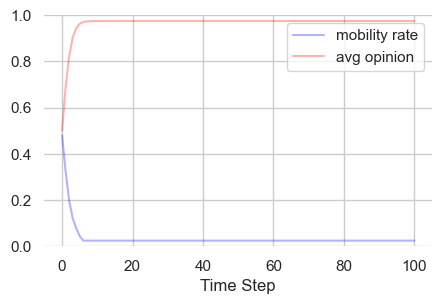

In [150]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [88]:
agents_data['decision'].value_counts()

decision
1    49991
0      509
Name: count, dtype: int64

# Peer Trust
### 1. PT = 0.2

In [151]:
model = opinionsModel(N = 500, PT = 0.2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

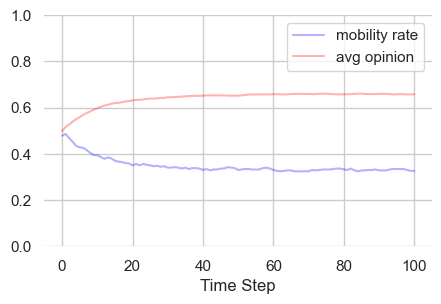

In [152]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 2. PT = 0.5

In [153]:
model = opinionsModel(N = 500, PT = 0.5)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

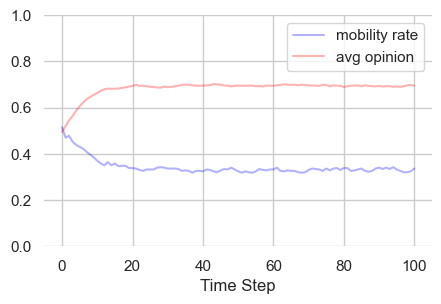

In [154]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 3. PT = 0.8

In [155]:
model = opinionsModel(N = 500, PT = 0.8)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

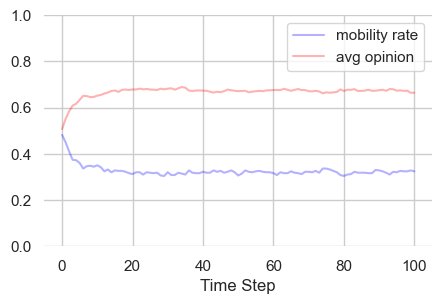

In [156]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

# Tendency to share
### 1. B = 0.2

In [157]:
model = opinionsModel(N = 500, B = 0.2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

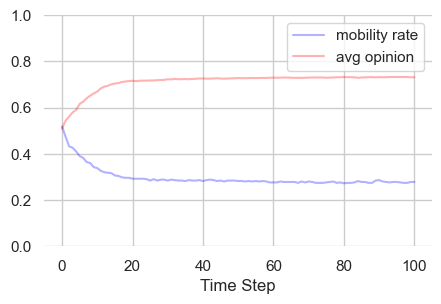

In [158]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 2. B = 0.5

In [159]:
model = opinionsModel(N = 500, B = 0.5)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

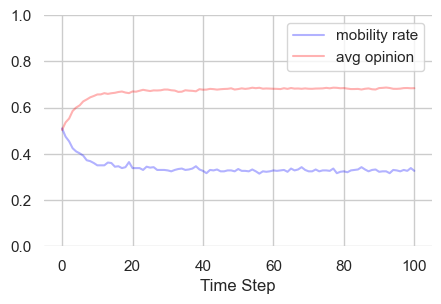

In [160]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

### 3. B = 0.8

In [161]:
model = opinionsModel(N = 500, B = 0.8)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

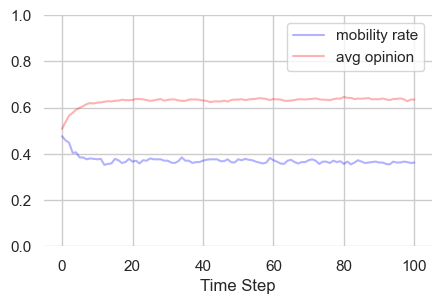

In [162]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

# different combination of values

In [163]:
model = opinionsModel(N = 500, PT = 0.5, B = 0.5, R = 1)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

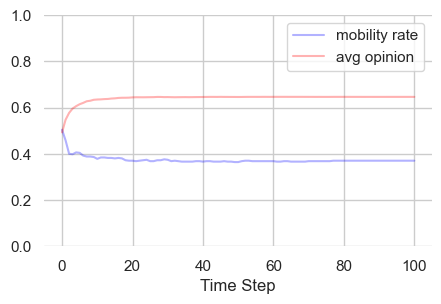

In [164]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [165]:
model = opinionsModel(N = 500, PT = 0.5, B = 0.5, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

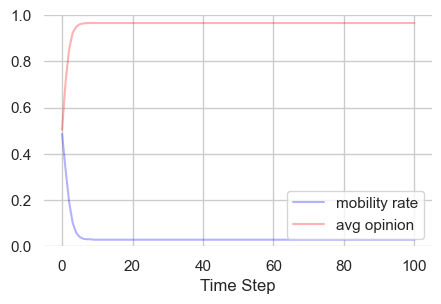

In [166]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [167]:
model = opinionsModel(N = 500, PT = 0.5, B = 0.5, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

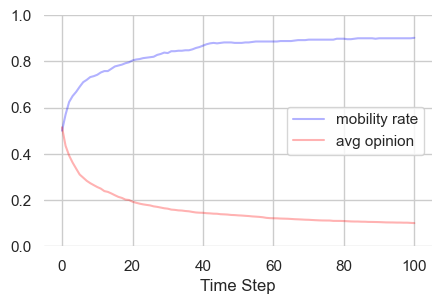

In [168]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [169]:
model = opinionsModel(N = 500, PT = 0.8, B = 0.2, R = 1)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

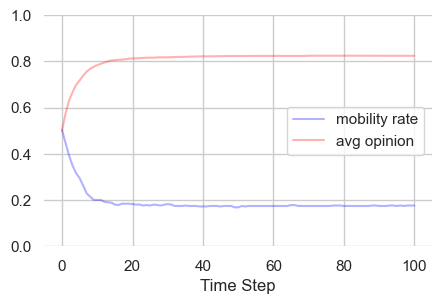

In [170]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [171]:
model = opinionsModel(N = 500, PT = 0.8, B = 0.2, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

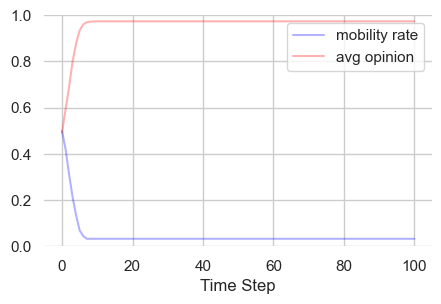

In [172]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [173]:
model = opinionsModel(N = 500, PT = 0.8, B = 0.2, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

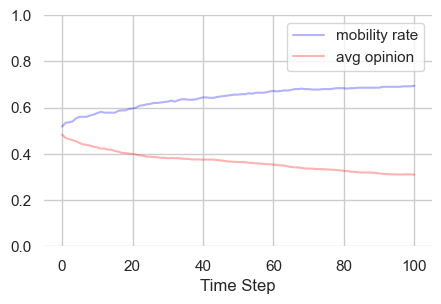

In [174]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [175]:
model = opinionsModel(N = 500, PT = 0.2, B = 0.8, R = 1)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

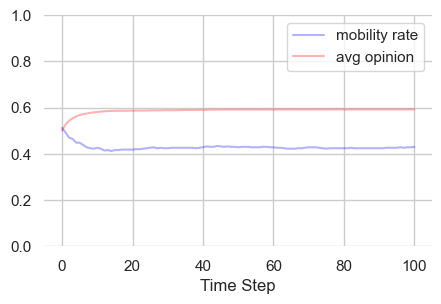

In [176]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [177]:
model = opinionsModel(N = 500, PT = 0.2, B = 0.8, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

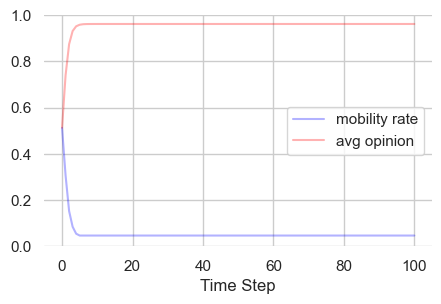

In [178]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [179]:
model = opinionsModel(N = 500, PT = 0.2, B = 0.8, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

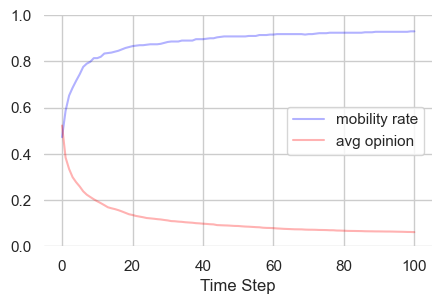

In [180]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

# fixed threshold for all agents

In [181]:
model = opinionsModel(N = 500, d = 0.8)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

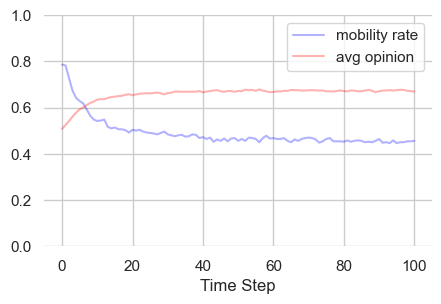

In [182]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [183]:
model = opinionsModel(N = 500, d = 0.5)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

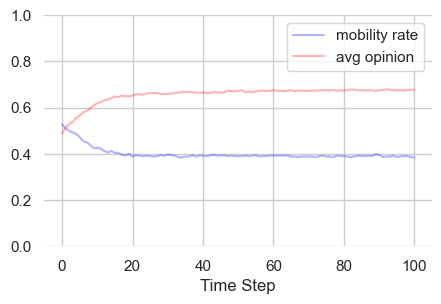

In [184]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()

In [185]:
model = opinionsModel(N = 500, d = 0.2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

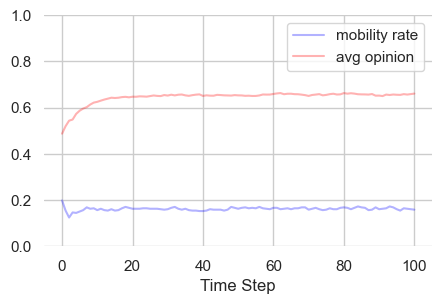

In [186]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.3, label= "mobility rate") 
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "red", alpha=0.3, label= "avg opinion")
    
plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("")
plt.show()